# Results

This Jupyter notebook is designed to demonstrate the loading of three distinct trained ensemble models, perform predictions on new data, and evaluate these predictions using several metrics: accuracy, recall, precision, and F1 score. The process encompasses obtaining predictions from individual learners within each ensemble and aggregating these predictions to form the final ensemble predictions. The evaluation metrics provide a comprehensive understanding of the ensemble models' performance on the given dataset.


## Import Required Libraries

First, we import all necessary libraries and modules. This includes standard data processing and machine learning libraries such as NumPy and joblib for model loading, and specific functions from scikit-learn for ensemble methods and metrics. We also suppress warnings to keep the notebook clean and more readable.

In [38]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import joblib
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import (
    accuracy_score, 
    recall_score, 
    precision_score, 
    f1_score
)
import matplotlib.pyplot as plt


## Load Dataset

In [39]:
def read_csv_file(filename: str) -> pd.DataFrame:
    """
    Read the given file. Raises an error and quits script
    if the file does not exist.

    Args:
        filename (str): A string filename. Must be a csv file.

    Returns:
        pd.DataFrame: A pandas data frame whose data can be
            manipulated
    """
    try:
        return pd.read_csv(
            filename, 
            lineterminator='\n',
            dtype={
                'label': float,
            },
        )
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

csv = read_csv_file('datasets/combined-hate-tagalog-taglish.csv')

csv

,text,label,Unnamed: 2
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0.0,NaN
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0.0,NaN
2,wait so ur telling me Let Leni Lead mo pero NY...,1.0,NaN
3,[USERNAME]wish this is just a nightmare that ...,0.0,NaN
4,doc willie ong and isko sabunutan po,0.0,NaN
...,...,...,...
28455,"Bisaya, Probinsyano/a, mostly Bisaya = katulong",1.0,NaN
28456,Amnesia. In my whole life wala pa ako nakasala...,1.0,NaN
28457,Kontrabida na ilang beses na tinalo at obvious...,1.0,NaN
28458,Yung antagonist laging kailangang sobrang sama...,1.0,NaN


### Get Test Data

In [40]:
def get_train_test_split(data_frame: pd.DataFrame):
    """
    Args:
        data_frame (pd.DataFrame): The data frame obtained from
            reading a csv file
    Returns:
        X_train
        X_test
        y_train
        y_test
    """
    text = data_frame['text']
    labels = data_frame['label']

    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        text, 
        labels, 
        test_size=0.2,  # 80/20 train/test split
        random_state=42,
    )

    return X_train, X_test, y_train, y_test

_, X_test, _, y_test = get_train_test_split(csv)

In [41]:
X_test

8374     Grabe andami ads ni Only Binay kawawa nmn taxe...
12922    LOOK Presidential candidate Ka Leody de Guzman...
18002    [USERNAME] Not like that Wharton-bred Mar Roxa...
26027    Uso mag move on [USERNAME] Roxas Quit Now POE2016
16004    [USERNAME] Mar Roxas and Binay. Both turned do...
                               ...                        
5418     Wala naman kasing maibibintang sayo kung walan...
28442    Maaga plng ba? Ang iingay ng mga tumatakbo sa ...
1977      [USERNAME] Oct Leody de Guzman should foster ...
27198    This is the most puzzling thing! No. 1 sa blac...
9098     Mr. Perfectly Fine [USERNAME] Enabler Never Ag...
Name: text, Length: 5692, dtype: object

In [42]:
y_test

array([1., 0., 1., ..., 0., 0., 1.])

## Results Functions

In [43]:
def get_ensemble_results(X_test: list, y_test: list, ensemble):
    """
    Predict with the trained ensemble using the csv data.
    Gives quantifiable results.

    Args:
        X_test: From the csv after train-test split
        y_test: From the csv after train-test split
        ensemble (VotingClassifier | StackingClassifier):
            A trained hard voting, soft voting, or stacking 
            ensemble from scikit-learn

    Returns:
        accuracy (float)
        recall (float)
        precision (float)
        f1 (float)
    """
    with torch.inference_mode():
        y_pred = ensemble.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        return accuracy, recall, precision, f1

In [51]:
def get_learner_results(X_test: list, y_test: list, ensemble):
    with torch.inference_mode():
        predictions = []
        for estimator in ensemble.estimators_:
            y_pred = estimator.predict(X_test)
            estimator_results = []
            estimator_results.append(accuracy_score(y_test, y_pred))
            estimator_results.append(recall_score(y_test, y_pred))
            estimator_results.append(precision_score(y_test, y_pred))
            estimator_results.append(f1_score(y_test, y_pred))
            predictions.append(estimator_results)
        return predictions

In [45]:
## Results Display Functions

In [80]:
def plot_grouped_bar_graph(data, labels, title="Performance Metrics"):
    data = np.array(data).T
    groups = len(data)
    num_of_bars = len(data[0])
    bar_width = 0.2
    bar_locations = np.arange(num_of_bars)
    bar_names = ('Accuracy', 'Precision', 'Recall', 'F1-score')

    # Create subplot
    fig, ax = plt.subplots()
    
    for i in range(groups):
        bars = ax.bar(bar_locations + i * bar_width, data[i], width=bar_width, label=bar_names[i])
        ax.bar_label(bars, fmt='%.2f', fontsize='small')

    ax.set_xlabel('Learners')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(bar_locations + 0.3, labels)
    ax.set_xticklabels(labels)
    ax.legend()
    
    plt.show()

learner_labels = ['Bernoulli Naive Bayes', 'LSTM', 'mBERT']

## Load Ensemble Models

Here, we load the pre-trained ensemble models from their respective files. These models have been saved previously using the joblib library, which allows for easy storage and loading of Python objects. Ensure that the paths to the model files ('ensemble1.pkl', 'ensemble2.pkl', 'ensemble3.pkl') are correct and accessible.

### Hard Ensemble

In [47]:
hard_ensemble = joblib.load('ensemble-hard.pkl')
hard_ensemble
#soft_ensemble = joblib.load('ensemble-soft.pkl')
#stack_ensemble = joblib.load('ensemble-stacking.pkl')

#ensembles = [hard_ensemble, soft_ensemble, stack_ensemble]

VotingClassifier(estimators=[('nb',
                              Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(stop_words=['akin',
                                                                           'aking',
                                                                           'ako',
                                                                           'alin',
                                                                           'am',
                                                                           'amin',
                                                                           'aming',
                                                                           'ang',
                                                                           'ano',
                                                                           'anumang',
                                                                           'apat',
                                                                           'at',
                                                                           'atin',
                                                                           'ating',
                                                                           'ay',
                                                                           'bababa',
                                                                           'bago',
                                                                           'bakit',
                                                                           'bawat',
                                                                           'bilang',
                                                                           'dahil',
                                                                           'dalawa',
                                                                           'dapat',
                                                                           'din',
                                                                           'dito',
                                                                           'doon',
                                                                           'gagawin',
                                                                           'gayunman',
                                                                           'ginagawa',
                                                                           'ginawa', ...])),
                                              ('bayes', BernoulliNB())]))...
                                               <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'src.LSTM.LstmModel'>,
  module__hidden_size=400,
))])),
                             ('bert',
                              Pipeline(steps=[('tokenizer',
                                               HuggingfacePretrainedTokenizer(max_length=255,
                                                                              tokenizer='bert-base-multilingual-cased')),
                                              ('bert',
                                               <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class 'src.BERT.BertModel'>,
))]))])

In [82]:
hard_ensemble_results = get_ensemble_results(X_test, y_test, hard_ensemble)

In [52]:
hard_ensemble_learners = get_learner_results(X_test, y_test, hard_ensemble)

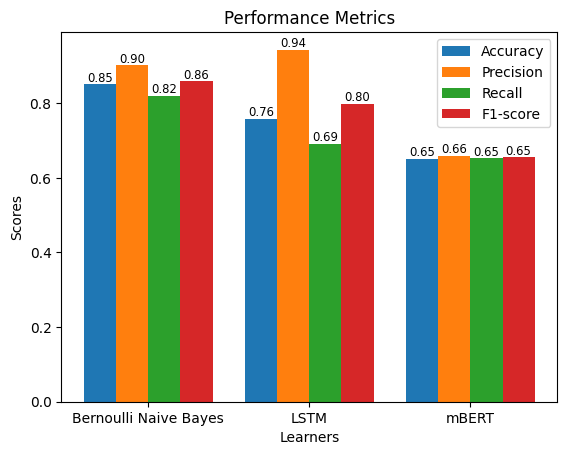

In [81]:
plot_grouped_bar_graph(hard_ensemble_learners, learner_labels, "Hard Voting Learners")

In [83]:
hard_ensemble = None
gc.collect()

15889

In [ ]:
soft_ensemble = joblib.load('ensemble-soft.pkl')
soft_ensemble

In [ ]:
soft_ensemble_results = get_ensemble_results(X_test, y_test, soft_ensemble)

In [ ]:
soft_ensemble_learners = get_learner_results(X_test, y_test, soft_ensemble)

## Define Input Data and True Labels

In this cell, we define the input data on which we want to make predictions. This data consists of a list of text samples. Additionally, we specify the true labels for these samples, which are required to evaluate the performance of our models. Replace the placeholder true labels with the actual labels corresponding to your input data.

In [ ]:
quotes = [
    "Gago ka putang ina", 
    'OIDAjodiajisjdai', 
    "You are a fucking bitch", 
    "NAKO  NAHIYA  YUNG  KAPAL  NG  PERA  NI  BINAY ", 
    "fuck you binay gago ka",
]

true_labels = np.array([1, 0, 1, 1, 1])  # Example placeholder labels

## Predictions and Metrics Evaluation

For each of the loaded ensemble models, we perform the following steps:
- Obtain final predictions for the input data. For hard voting classifiers, we directly use the 'predict' method. For soft voting classifiers or other ensemble types, we use the 'predict_proba' method and then derive predictions based on the highest probability.
- Evaluate the models' predictions using four metrics: accuracy, recall, precision, and F1 score. These metrics provide a holistic view of the models' performance, indicating not only their overall correctness (accuracy) but also how well they manage positive class predictions (recall and precision) and the balance between recall and precision (F1 score).

In [ ]:
for idx, ensemble in enumerate(ensembles, start=1):
    print(f"=== Ensemble Model {idx} ===")
    
    # Final ensemble predictions
    if isinstance(ensemble, VotingClassifier) and ensemble.voting == 'hard':
        predictions = ensemble.predict(quotes)
    else:
        # Assuming binary classification and taking the class with the higher probability
        predictions_proba = ensemble.predict_proba(quotes)
        predictions = np.argmax(predictions_proba, axis=1)
    
    # Metrics evaluation
    accuracy = accuracy_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1}\n")